                                AMAZON FINE FOODS ANALYSIS

# Data Review and Preparation

In [0]:
# Importing libraries

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

In [11]:
#load from google drive - it promp for authorization code- follow the link prompted below the cell and find the same
from google.colab import drive
drive.mount('/content/drive')

#navigate to that file and right click on file and copy path
#/content/drive/My Drive/Datasets/Case studies/amazon fine foods/Reviews.csv

#importing the review data

#df=pd.read_csv("D:/MLAI/3. Applied AI course/Asgnmnt 2 Amazon Fine Food Reviews_TSNE/Reviews.csv")
df = pd.read_csv('/content/drive/My Drive/Datasets/Case studies/amazon fine foods/Reviews.csv')
df=df.head(5000)
print("length of the imported data =",len(df))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of the imported data = 5000


## Check for missing data

In [15]:
# Columns with Missing value
pd.isnull(df).any(axis=0) #axis 0 -> going down the rows for every column

Unnamed: 0                False
Id                        False
ProductId                 False
UserId                    False
ProfileName               False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                   False
Text                      False
dtype: bool

## Checking for data irregularities

In [16]:
# lines where numerator is > denominator
len(df[(df["HelpfulnessDenominator"])<(df["HelpfulnessNumerator"])])

0

In [20]:
#Dataframe where the Denominator >= Numerator and the score is not equal to 3
polar_df = df[(df["HelpfulnessDenominator"]>=df["HelpfulnessNumerator"]) & (df["Score"]!=3)] 
print('length of the revised dataframe where score not equal to 3 is ',len(polar_df))


length of the revised dataframe where score not equal to 3 is  4605


In [24]:
# checking for complete row duplicates

print("The number of duplicates rows = ",len(polar_df[polar_df.duplicated(keep="first")]))


The number of duplicates rows =  0


In [26]:
# Checking for duplicate user ID, Time,Text
# duplicated keep false - Mark all duplicates as True.
polar_df[polar_df[["UserId","Time","Text"]].duplicated(keep=False)].loc[(polar_df["ProfileName"]=="Karl") & (polar_df["Text"] == polar_df.loc[3,"Text"])]

Empty DataFrame
Columns: [Unnamed: 0, Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []

In [0]:
# Dropping duplicates

df1=df1.drop_duplicates(subset={"UserId","Time","Text"},keep="first")
df1=df1.reset_index()
print("The Number of rows WITHOUT same UserId,Time,Text =",len(df1))
print('% of original data remaining =',round(len(df1)/len(df)*100,2))

The Number of rows WITHOUT same UserId,Time,Text = 4592
% of original data remaining = 91.84


## Modifying the output data for analysis

In [0]:
# Tagging reviews as positive and negative
# df1=df1.reset_index()
df1["Rev_pol"]=df1["Score"]

df1["Rev_pol"]=df1["Rev_pol"].replace(to_replace=[1,2],value="negative")
df1["Rev_pol"]=df1["Rev_pol"].replace(to_replace=[4,5],value="positive")
df1.head(2)

index  Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text   Rev_pol  
0  I have bought several of the Vitality canned d...  positive  
1  Product arrived labeled as Jumbo Salted Peanut...  negative

## Text clean-up

In [0]:
stop=set(stopwords.words("english")) # set of stopword
sno=nltk.stem.SnowballStemmer("english") # Initializng stemmer

def cleanhtml(sentence):
    cleant=re.compile("<.*?>")
    cleantext=cleant.sub("",sentence)
    return cleantext

def cleanpunc(sentence):
    cleanp=re.sub(r'[?|!|"|\'|#]',"",sentence)
    cleanp=re.sub(r'[.|,|)|(|\\|/)]'," ",cleanp)
    return cleanp


In [0]:
# Code for imlplementation on all the text

i=0
all_positive_words=[]
all_negative_words=[]
final_string=[]

for sent in df1["Text"].values:
    list_words=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if cleaned_words.lower() not in stop:
                    s=(sno.stem(cleaned_words.lower()))
                    list_words.append(s)
                    if (df1["Rev_pol"].values)[i]=="positive":
                        all_positive_words.append(s)
                    if (df1["Rev_pol"].values)[i]=="negative":
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    stri1=" ".join(list_words)
    final_string.append(stri1)
    i+=1
    
df1["New_text"]=final_string
df1["New_text"]

0       bought sever vital can dog food product found ...
1       product arriv label jumbo salt peanut peanut a...
2       confect around centuri light pillowi citrus ge...
3       look secret ingredi robitussin believ found go...
4       great taffi great price wide assort yummi taff...
                              ...                        
4587    paleo caveman primal diet ador cookiesotherwis...
4588    realli want like first cooki size half dollar ...
4589    impress cooki tri first came compani one flavo...
4590    tast good arent like best thing ever either or...
4591    love cooki paleo diet right cooki look forward...
Name: New_text, Length: 4592, dtype: object

## Train Test split

In [0]:
#Splitting data into train and test befre vectorization to prevent 

X_train,X_test,y_train,y_test=train_test_split(df1,df1["Rev_pol"],test_size=0.25)

## BoW Vectorization

In [0]:
# Learning Bow vectorization on train data

count_vect=CountVectorizer() # in sklearn
train_counts=count_vect.fit_transform(X_train["New_text"]).toarray()

# Transforming test data
test_counts=count_vect.transform(X_test["New_text"]).toarray()

### Implementing TSNE

In [0]:
# tSNE transformation
from sklearn.manifold import TSNE

tSNE_data=TSNE(random_state=0).fit_transform(train_counts)

In [0]:
tSNE_df=pd.DataFrame(tSNE_data)
labels_df=pd.DataFrame(y_train)
tSNE_out=pd.concat([tSNE_df,labels_df],axis=1,ignore_index=True)
tSNE_out=tSNE_out.rename(columns={0:"Dim 1",1:"Dim 2",2:"label"})
tSNE_out=tSNE_out.dropna()
tSNE_out

Dim 1      Dim 2     label
0    -10.020000  14.459155  positive
1     12.436212  14.383138  negative
2      6.755344   3.009774  positive
3      0.105875   2.821674  negative
5     17.003355  -6.339433  positive
...         ...        ...       ...
3435  -2.007641  -6.808944  positive
3436  14.756397  14.119909  positive
3437  24.336231  -9.243376  positive
3441   1.291708  -0.352347  positive
3443  -8.516359 -11.847595  positive

[2585 rows x 3 columns]

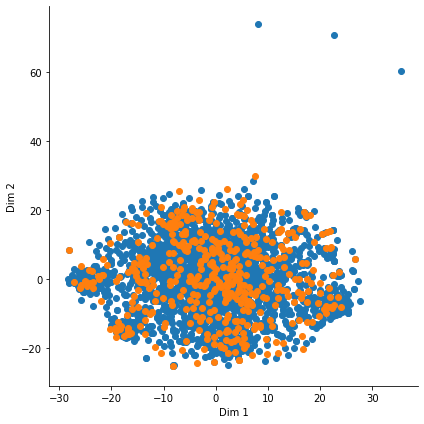

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.FacetGrid(tSNE_out, hue="label",height=6).map(plt.scatter,"Dim 1","Dim 2")
plt.show()

### Impelmenting Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

clf_nb=GaussianNB(priors=None, var_smoothing=1e-09)
clf_nb.fit(train_counts,y_train)
clf_nb.score(test_counts,y_test)

0.6193379790940766

### Implementating Logistic Regression 

In [0]:
# Running logistic regression to learn classification to "positive" and "negative" reviews
log=LogisticRegressionCV(Cs=[10**-4,10**-2,10**0,10**2,10**4],cv=5,max_iter=1000,random_state=42)

clf=log.fit(train_counts,y_train)

In [0]:
# printing the coeff (i.e. weight vector) (NEED TO BETTER THIS - GET THE WORD AND THE WEIGHT)

clf.coef_

array([[ 0.00078864,  0.0005514 ,  0.00551091, ..., -0.03784248,
         0.01872843,  0.00034372]])

#### Learning and validation plots

In [0]:
# Plotting train and validation scores for multiple Hyperparamater 'C' value
from sklearn.model_selection import validation_curve


train_scores, valid_scores = validation_curve(LogisticRegression(max_iter=1000), train_counts, y_train, "C",[10**-4,10**-2,10**-1,10**0],cv=5)
print(train_scores)
print(valid_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

[[0.82976407 0.82976407 0.82976407 0.83012704 0.82982583]
 [0.85117967 0.85154265 0.85117967 0.85190563 0.84869376]
 [0.93974592 0.94047187 0.9430127  0.93865699 0.93795356]
 [0.99419238 0.9923775  0.99274047 0.99201452 0.99492017]]
[[0.83018868 0.83018868 0.83018868 0.8287373  0.82994186]
 [0.83599419 0.83889695 0.83309144 0.83599419 0.8372093 ]
 [0.86357039 0.87227866 0.87227866 0.87808418 0.87790698]
 [0.86211901 0.87953556 0.86502177 0.89550073 0.88662791]]


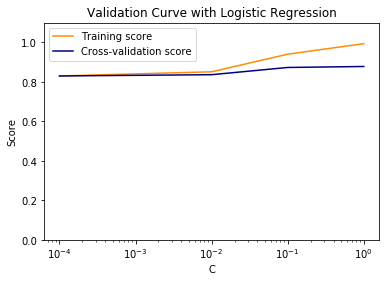

In [0]:
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
# lw = 2
plt.semilogx([10**-4,10**-2,10**-1,10**0], train_scores_mean, label="Training score",
             color="darkorange")
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
plt.semilogx([10**-4,10**-2,10**-1,10**0], valid_scores_mean, label="Cross-validation score",
             color="navy")
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

(array([0.70769231, 0.92534381]), array([0.54761905, 0.96122449]), array([0.61744966, 0.94294294]), array([168, 980], dtype=int64))
Confusion matrix, without normalization
[[ 92  76]
 [ 38 942]]


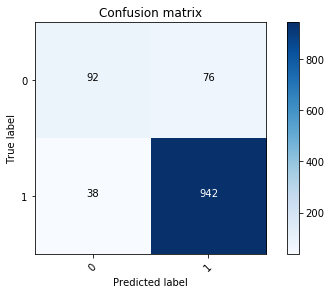

In [0]:
# Credit: @ WilsonF (https://www.kaggle.com/wilsonf/logistic-regression-cv-test)
#Printing the cross validation and training scores

import matplotlib.pyplot as plt
from sklearn import metrics
import itertools

from sklearn.metrics import precision_recall_fscore_support
y_pred=clf.predict(test_counts)
print(precision_recall_fscore_support(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plotting the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

In [0]:
clf.score(test_counts,y_test) 

0.9006968641114983

### SVC Implementation

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#### Hyperparameter search

In [0]:
# @ sklearn : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring='%s' % score,cv=3)
    clf.fit(train_counts, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.830 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.830 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.860 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.830 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.869 (+/-0.016) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.861 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}



In [0]:
# Truning to run metrics for the selected hyperparameters 

from sklearn.metrics import classification_report

tuned_parameters_new = [{'kernel': ['rbf'], 'gamma': [.001],
                     'C': [100]}]

scores_new = ['accuracy']
clf_svc = GridSearchCV(SVC(), tuned_parameters_new, scoring='%s' % score,cv=3)
clf_svc.fit(train_counts, y_train)

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf_svc.predict(test_counts)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

    negative       0.67      0.56      0.61       168
    positive       0.93      0.95      0.94       980

    accuracy                           0.90      1148
   macro avg       0.80      0.76      0.78      1148
weighted avg       0.89      0.90      0.89      1148




In [0]:
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(test_counts)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

    negative       0.67      0.56      0.61       168
    positive       0.93      0.95      0.94       980

    accuracy                           0.90      1148
   macro avg       0.80      0.76      0.78      1148
weighted avg       0.89      0.90      0.89      1148




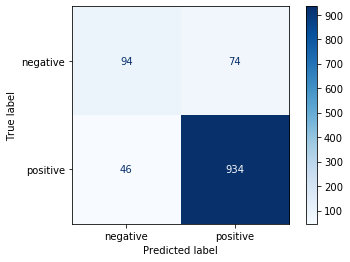

In [0]:
from  sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, test_counts, y_test, labels=None, sample_weight=None, normalize=None, display_labels=None, include_values=True, xticks_rotation='horizontal', values_format=".0f", cmap='Blues', ax=None)

In [0]:
clf_svc=SVC( kernel='rbf', degree=3, 
            gamma=.001, coef0=0.0, shrinking=True, 
            probability=False, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=-1, 
            decision_function_shape='ovr', break_ties=False, random_state=42)

train_scores_svc, valid_scores_svc = validation_curve(clf_svc, train_counts,y_train,"C",[1, 10, 100], y_train,cv=3)
print("Train Score:")
print(train_scores_svc)
print("Test Score:")
print(valid_scores_svc)
train_scores_svc_mean = np.mean(train_scores_svc, axis=1)
train_scores_svc_std = np.std(train_scores_svc, axis=1)
valid_scores_svc_mean = np.mean(valid_scores_svc, axis=1)
valid_scores_svc_std = np.std(valid_scores_svc, axis=1)

Train Score:
[[0.83101045 0.83057491 0.83101045]
 [0.91942509 0.91811847 0.91158537]
 [0.99303136 0.99259582 0.99608014]]
Test Score:
[[0.83013937 0.83013937 0.82926829]
 [0.86062718 0.85801394 0.86236934]
 [0.8597561  0.86759582 0.87979094]]


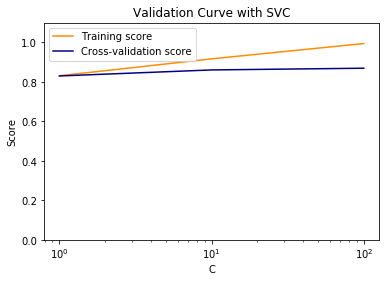

In [0]:
plt.title("Validation Curve with SVC")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)

plt.semilogx([1, 10, 100], train_scores_svc_mean, label="Training score",
             color="darkorange")

plt.semilogx([1, 10, 100], valid_scores_svc_mean, label="Cross-validation score",
             color="navy")

plt.legend(loc="best")
plt.show()

### Implementing Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=0,oob_score=True)
rfc.fit(train_counts,y_train)
print("Test Score with Random Forest:")
print(rfc.score(test_counts,y_test))
rfc.oob_score_

Test Score with Random Forest:
0.8850174216027874


0.8568524970963995

### GBDT Implementation

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

GBDT_clf=GradientBoostingClassifier(random_state=0)
GBDT_clf.fit(train_counts,y_train)
print("Test Score with GBDT:")
GBDT_clf.score(test_counts,y_test)

Test Score with GBDT:


0.8867595818815331

## Implementing Word2Vec Vectorization

In [0]:
# Using Google news Word2Vectors

from gensim import models
from gensim.models import KeyedVectors
import pickle

model = models.KeyedVectors.load_word2vec_format(
    'D:/W2V/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True,limit=1000000)


KeyboardInterrupt: 

In [0]:
# model.most_similar("tiger")

In [0]:
list_of_sentence=[]

for sent in df1["New_text"]:
    list_of_sentence.append(sent.split())

print(len(list_of_sentence))

4592


In [0]:
from tqdm import tqdm

w2v_words = list(model.wv.vocab)

sent_vec_list=[]


for sent in tqdm(list_of_sentence):
    sent_temp_vec=np.zeros(300)
    count=0;
#     print(sent)
    for word in sent:
#         print(word)
        if word in w2v_words:
            w_vec=model[word]
#             print(w_vec)
            sent_temp_vec=sent_temp_vec+w_vec
#             print(sent_temp_vec)
            count=count+1
    if count!=0:
        sent_temp_vec/=count
    sent_vec_list.append(sent_temp_vec)
print(len(sent_vec_list))
print(len(sent_vec_list[0]))
sent_vec_list

C:\Users\Ratish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 4592/4592 [16:41<00:00,  4.58it/s]  


4592
300


[array([-2.81013489e-02,  2.86071777e-02, -2.46788025e-02,  1.05583191e-01,
        -5.83068371e-02,  5.53665161e-02,  7.94624329e-02, -6.80315971e-02,
         3.24455261e-02,  6.30493164e-02, -2.53295898e-02, -1.68780518e-01,
        -5.85845947e-02, -1.45568848e-02, -1.19213867e-01,  8.29631805e-02,
         3.66844177e-02,  1.12628174e-01, -7.08206177e-02, -6.33056641e-02,
         1.16821289e-02,  1.47399902e-02,  6.60171509e-03,  3.28094482e-02,
         6.92276001e-02,  7.97119141e-03, -9.07608032e-02,  7.45273590e-02,
         4.33982849e-02,  4.00505066e-03, -7.00012207e-02, -1.77001953e-04,
        -7.39841461e-03, -2.89001465e-02,  3.08288574e-02,  2.42897034e-02,
         5.76423645e-02, -8.16131592e-02,  5.98388672e-02,  1.01867676e-01,
         1.77124023e-02, -1.01647186e-01,  6.67179108e-02, -4.37316895e-03,
        -1.05294800e-01, -1.23876953e-01, -3.04367065e-02,  5.89614868e-02,
        -2.64343262e-02,  5.52424908e-02,  1.59545898e-02,  2.15759277e-02,
        -2.4

### Train  Test Split

In [0]:
#Splitting data into train and test befre vectorization to prevent 

X_train_w2v,X_test_w2v,y_train_w2v,y_test_w2v=train_test_split(sent_vec_list,df1["Rev_pol"],test_size=0.25,stratify=df1["Rev_pol"])
print("Length of the X in train dataset is =",len(X_train_w2v))
print("Length of the y in train dataset is =",len(y_train_w2v))

Length of the X in train dataset is = 3444
Length of the y in train dataset is = 3444


### Implementing TSNE

In [0]:
# tSNE transformation
from sklearn.manifold import TSNE

tSNE_data=TSNE(random_state=0,perplexity=30,n_iter=5000).fit_transform(X_train_w2v)

In [0]:
tSNE_df=pd.DataFrame(tSNE_data)
labels_df=pd.DataFrame(y_train_w2v)
tSNE_out=pd.concat([tSNE_df,labels_df],axis=1,ignore_index=True)
tSNE_out=tSNE_out.rename(columns={0:"Dim 1",1:"Dim 2",2:"label"})
tSNE_out=tSNE_out.dropna()
tSNE_out

Dim 1      Dim 2     label
0    -16.200890  -0.959746  positive
1    -13.669245  -4.711307  negative
2      4.198894 -37.346012  positive
3     30.525167 -17.227875  negative
4    -47.457706  14.194970  positive
...         ...        ...       ...
3437 -19.069515  21.215189  positive
3438  29.130966  19.012634  positive
3440   9.150137  12.017563  positive
3442  10.116345   4.558861  positive
3443  14.713017 -12.539866  positive

[2581 rows x 3 columns]

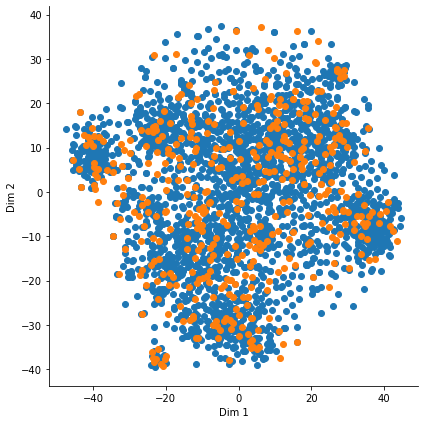

In [0]:
import seaborn as sn0
import matplotlib.pyplot as plt

sn.FacetGrid(tSNE_out, hue="label",height=6).map(plt.scatter,"Dim 1","Dim 2")
plt.show()

In [0]:
print("Number of negative cases = ",len(tSNE_out[(tSNE_out["label"]=='negative')]))
print("Number of positive cases = ",len(tSNE_out[(tSNE_out["label"]=='positive')]))

Number of negative cases =  435
Number of positive cases =  2146


 ### Implementing Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

clf_nb=GaussianNB(priors=None, var_smoothing=1e-09)
clf_nb.fit(X_train_w2v,y_train_w2v)
clf_nb.score(X_test_w2v,y_test_w2v)

0.6637630662020906

 ### logistic Regression Implemention

In [0]:
# Running logistic regression to learn classification to "positive" and "negative" reviews
log=LogisticRegressionCV(Cs=[10**-4,10**-2,10**0,10**2,10**4,10**6],cv=5,max_iter=1000,random_state=42)

clf=log.fit(X_train_w2v,y_train_w2v)

In [0]:
# Plotting train and validation scores for multiple Hyperparamater 'C' value
from sklearn.model_selection import validation_curve


train_scores, valid_scores = validation_curve(LogisticRegression(max_iter=1000), X_train_w2v, y_train_w2v, "C",[10**-2,10**0,10**2,10**4,10**6],cv=5)
print(train_scores)
print(valid_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

[[0.83557169 0.83557169 0.83557169 0.83593466 0.83563135]
 [0.86606171 0.86315789 0.8646098  0.86569873 0.86357039]
 [0.9215971  0.91905626 0.91361162 0.91288566 0.90856313]
 [0.92377495 0.92014519 0.92050817 0.91506352 0.90783745]
 [0.92377495 0.92050817 0.92050817 0.9154265  0.90783745]]
[[0.83599419 0.83599419 0.83599419 0.83454282 0.83575581]
 [0.86066763 0.86211901 0.85341074 0.8563135  0.85755814]
 [0.83889695 0.85341074 0.85776488 0.86211901 0.87936047]
 [0.83164006 0.85341074 0.83889695 0.85050798 0.86918605]
 [0.83164006 0.85341074 0.83889695 0.85050798 0.86918605]]


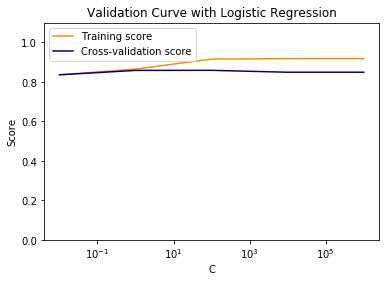

In [0]:
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
# lw = 2
plt.semilogx([10**-2,10**0,10**2,10**4,10**6], train_scores_mean, label="Training score",
             color="darkorange")
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
plt.semilogx([10**-2,10**0,10**2,10**4,10**6], valid_scores_mean, label="Cross-validation score",
             color="navy")
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

(array([0.59863946, 0.9000999 ]), array([0.46808511, 0.93854167]), array([0.52537313, 0.91891892]), array([188, 960], dtype=int64))
Confusion matrix, without normalization
[[ 88 100]
 [ 59 901]]


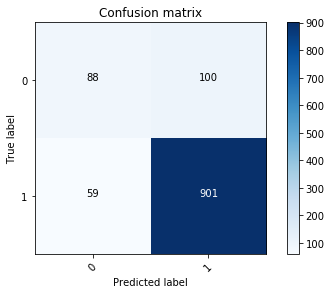

In [0]:
# Credit: @ WilsonF (https://www.kaggle.com/wilsonf/logistic-regression-cv-test)
#Printing the cross validation and training scores

import matplotlib.pyplot as plt
from sklearn import metrics
import itertools

from sklearn.metrics import precision_recall_fscore_support
y_pred=clf.predict(X_test_w2v)
print(precision_recall_fscore_support(y_test_w2v, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test_w2v, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plotting the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

### SVC Implementation

In [0]:
# @ sklearn : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 
                     'C': [10**-2,10**0,10**2,10**4]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(gamma="auto"), tuned_parameters, scoring='%s' % score,cv=3)
    clf.fit(X_train_w2v, y_train_w2v)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10000, 'kernel': 'rbf'}

Grid scores on development set:

0.836 (+/-0.001) for {'C': 0.01, 'kernel': 'rbf'}
0.836 (+/-0.001) for {'C': 1, 'kernel': 'rbf'}
0.843 (+/-0.007) for {'C': 100, 'kernel': 'rbf'}
0.850 (+/-0.019) for {'C': 10000, 'kernel': 'rbf'}



### Random Forest Implemantation

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=0,oob_score=True)
rfc.fit(X_train_w2v,y_train_w2v)
print("Test Score with Random Forest:")
print(rfc.score(X_test_w2v,y_test_w2v))
rfc.oob_score_

Test Score with Random Forest:
0.8362369337979094


0.8371080139372822

### GBDT Implementation

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

GBDT_clf=GradientBoostingClassifier(random_state=0)
GBDT_clf.fit(X_train_w2v,y_train_w2v)
print("Test Score with GBDT:")
GBDT_clf.score(X_test_w2v,y_test_w2v)

Test Score with GBDT:


0.8527874564459931